## Proyecto: **Conjunto de Modelos (Ensemble methods)**

## Importando y preprocesando datasets

- Diabetes dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database <br/>
- Ionosphere dataset: https://archive.ics.uci.edu/ml/datasets/ionosphere <br/>
- Credit Approval dataset: https://archive.ics.uci.edu/ml/datasets/Credit+Approval

In [1]:
import pandas as pd 
import numpy as np
import math
from itertools import combinations

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

Importando datasets

In [2]:
# dataset Diabetes
X_dia = pd.read_csv("diabetes.csv", header=0)
y_dia = X_dia['Outcome'].copy()
X_dia.drop('Outcome', axis='columns', inplace = True)
X_dia.columns = range(X_dia.shape[1])

# dataset Ionosphere
X_ion = pd.read_csv("ionosphere.data", header = None)
y_ion = X_ion[34].copy()
X_ion.drop(34, axis='columns', inplace = True)
for i in range(len(y_ion)):
    if y_ion.iloc[i] == 'g':
        y_ion.iloc[i] = 1
    else:
        y_ion.iloc[i] = 0

# dataset Credit approval
X_cre = pd.read_csv("crx.data", header = None)

Eliminamos patrones con valores NaN (dados por el caracter '?'). Cambiamos las variables categóricas del dataset "Credit approval". 

In [3]:
indexEliminate = []
for i in range(X_cre.shape[0]):
    for j in range(X_cre.shape[1]):
        if X_cre[j].iloc[i] == '?':
            indexEliminate.append(i)    
            break

X_cre.drop(indexEliminate, axis = 'index', inplace = True)
X_cre.index = np.array(range(X_cre.shape[0]))

In [4]:
labelEncoder = LabelEncoder()
for i in [0,3,4,5,6,8,9,11,12]:
    # Para cada columna con datos categoricos, cambiar datos a numeros
    attribute = labelEncoder.fit_transform(X_cre[i])
    X_cre[i] = attribute

y_cre = X_cre[15].copy()
X_cre.drop(15, axis='columns', inplace = True)

for i in range(len(y_cre)):
    if y_cre.iloc[i] == '+':
        y_cre.iloc[i] = 1
    else:
        y_cre.iloc[i] = 0

In [5]:
y_ion = y_ion.astype(int, copy=False)
y_cre = y_cre.astype(int, copy=False)
X_cre = X_cre.astype({1:float,13:'int32'}, copy=False)

División de 5 datasets. Para esto nos apoyamos de la función `StratifiedShuffleSplit` de Scikit-Learn (ver <a href = https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html >documentación</a>)

In [6]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=0)

Ejemplo de cómo funciona `StratifiedShuffleSplit`:

In [7]:
for train_index, test_index in sss.split(X_cre, y_cre):
    print(train_index[:10])
    print(test_index[:10])

[391 372 426 351 318 124 546 284 547 169]
[648 250 367 230 498 240 304 275 395 623]
[478 500 132 204 479 128 141 199 402 224]
[ 38 612 429 274 157  54  99 574 575 422]
[532 147 120  55 383 439  15  90 329 192]
[ 95 244 380 180 291 306 466 343 381 387]
[477 616 631 261 375  56 144 391 466 189]
[242 452 204  32 181 291 111 608 486  69]
[508 445 474 457 614 266  87 105 172 206]
[579 469 440 443 208 335 291 226 179 102]


In [8]:
for train_index, test_index in sss.split(X_dia, y_dia):
    print(train_index[:10])
    print(test_index[:10])

[250  72 584 348 298 601 410 531 337 480]
[235 427 455 153 333 692 107  78 386 720]
[408 623 238 582  74  14 121 278 210 682]
[467 478 628 451  89 375 273 320 504 669]
[223 545 664 703 682 148 623 104 717 247]
[621 412 262 639 261 681 356 125 424 180]
[624  58 581 468 752 406 219 754 658 319]
[751  73 404 328   7 477 184 175 322 707]
[141 650 348 444 296 533 301 661 190  30]
[167 511 676 171 267 439 660 577 538 432]


In [9]:
# Para escalar datos
scaler = MinMaxScaler()

### Funciones para el ensamble paralelo heterogéneo

In [10]:
def fit_ensemble(classifiers, X, y):
  for i in range(len(classifiers)):
    classifiers[i].fit(X, y)

def predict_individual(classifiers, X):
  y_pred = [] # y[i] son las predicciones del clasificador i para X
  for i in range(len(classifiers)):
    y_pred.append(classifiers[i].predict(X))

  return y_pred

def defineWeights(classifiers, X_val, y_val):
  y_pred = predict_individual(classifiers, X_val) # y[i] son las predicciones del clasificador i para X_val
  ac = [] # ac[i] es el accuracy del clasificador i utilizando el conjunto de validacion X_val
  for i in range(len(classifiers)):
    ac.append(accuracy_score(y_val, y_pred[i]))

  ac = np.array(ac)
  normalizer = ac.sum()

  return ac/normalizer

def predict_ensemble(classifiers, weights, X):
  y_pred_ind = predict_individual(classifiers, X)

  y_pred = [] # y_pred[i] es la prediccion del patron i

  for i in range(X.shape[0]):
    y_pred.append(0.0)
    for j in range(len(classifiers)):
      y_pred[i] += weights[j]*y_pred_ind[j][i]

    if y_pred[i] >= 0.5:
      y_pred[i] = 1
    else:
      y_pred[i] = 0

  return y_pred

## Escoge el dataset

Si quiere utilizar el Diabetes dataset, dejar la descomentada la línea con el comentario 

```
# Diabetes dataset
```

 y comentar las otras dos en las siguiente línea en la celda de abajo. Análogamente con los otros datasets

In [54]:
parameters_dia = [50, (20,20,20), 'relu', 100, 100, 100, 20]
parameters_ion = [10, (100,), 'relu', 100, 100, 100, 20]
parameters_cre = [10, (100,), 'relu', 100, 100, 100, 20]

X, y, parameters = X_dia, y_dia, parameters_dia  # Diabetes dataset
#X, y, parameters = X_ion, y_ion, parameters_ion # Ionosphere dataset
#X, y, parameters = X_cre, y_cre, parameters_cre # Credit Approval Dataset

maxdepth = parameters[0]
hidden_layer_sizes = parameters[1]
activation = parameters[2]
n_estimators = [parameters[3], parameters[4], parameters[5], parameters[6]]

graphCobertura_ejeX = []
graphCobertura_ejeY = []

## Modelos individuales

- Gaussian Naive Bayes
- Decision Tree
- Artificial Neural Networks


In [55]:
# Clasificadores
classifier = [] 
classifier.append(GaussianNB())
classifier.append(DecisionTreeClassifier(criterion='entropy', max_depth=maxdepth))
classifier.append(MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000, activation=activation, solver='sgd'))

In [56]:
# confusionMatrix es la matrix de confusion promedio del Random Forest para el conjunto de prueba
confusionMatrix = np.array([np.zeros((2,2)) for i in range(3)])

for train_index, test_index in sss.split(X, y):
        
    # escalamos dataset
    X_train = scaler.fit_transform(X.iloc[train_index])
    X_test = scaler.transform(X.iloc[test_index])
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    for i, cl in  enumerate(classifier):
      cl.fit(X_train, y_train)
      y_pred = cl.predict(X_test)

      cm = confusion_matrix(y_test, y_pred)

      confusionMatrix[i] += cm

confusionMatrix /= 5.0

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [57]:
print("Naive Bayes")
print(confusionMatrix[0])
print((confusionMatrix[0][0][0]+confusionMatrix[0][1][1])/confusionMatrix[0].sum())
print("Decision Tree")
print(confusionMatrix[1])
print((confusionMatrix[1][0][0]+confusionMatrix[1][1][1])/confusionMatrix[1].sum())
print("Neural Network")
print(confusionMatrix[2])
print((confusionMatrix[2][0][0]+confusionMatrix[2][1][1])/confusionMatrix[2].sum())

Naive Bayes
[[134.4  30.6]
 [ 36.4  52.6]]
0.7362204724409449
Decision Tree
[[129.   36. ]
 [ 37.6  51.4]]
0.710236220472441
Neural Network
[[155.6   9.4]
 [ 69.8  19.2]]
0.6881889763779527


## Random Forest

In [58]:
# confusionMatrix es la matrix de confusion promedio del Random Forest para el conjunto de prueba
confusionMatrix = np.zeros((2,2)) 

for train_index, test_index in sss.split(X, y):
        
    # escalamos dataset
    X_train = scaler.fit_transform(X.iloc[train_index])
    X_test = scaler.transform(X.iloc[test_index])
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    rf = RandomForestClassifier(max_depth=maxdepth, n_estimators= n_estimators[0], oob_score=True, n_jobs= -1)

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    confusionMatrix += cm

confusionMatrix /= 5.0

In [59]:
print(confusionMatrix)
print((confusionMatrix[0][0]+confusionMatrix[1][1])/confusionMatrix.sum())
graphCobertura_ejeX.append(confusionMatrix[0][1]/(confusionMatrix[0][0]+confusionMatrix[0][1]))
graphCobertura_ejeY.append(confusionMatrix[1][1]/(confusionMatrix[1][0]+confusionMatrix[1][1]))

[[138.6  26.4]
 [ 37.4  51.6]]
0.7488188976377952


## Ensamble paralelo homogéneo con estimadores base:

- Gaussian Naive Bayes
- Decision Tree
- Artificial Neural Networks

In [60]:
# Clasificadores
classifier = [] 
classifier.append(GaussianNB())
classifier.append(DecisionTreeClassifier(criterion='entropy', max_depth=maxdepth))
classifier.append(MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000, activation=activation, solver='sgd'))

In [61]:
# confusionMatrix[i] es la matrix de confusion promedio del clasificador i para el conjunto de prueba
confusionMatrix = [np.zeros((2,2)) for i in range(3)]

for train_index, test_index in sss.split(X, y):
        
  # escalamos dataset
  X_train = scaler.fit_transform(X.iloc[train_index])
  X_test = scaler.transform(X.iloc[test_index])
  y_train = y.iloc[train_index]
  y_test = y.iloc[test_index]

  # iteramos sobre los primeros 3 clasificadores
  for i in range(3):
    bagging = BaggingClassifier(base_estimator = classifier[i], n_estimators = n_estimators[i+1], 
                                oob_score = True, n_jobs = -1)

    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    confusionMatrix[i] += cm


for i in range(3):
  confusionMatrix[i] /= 5.0

In [62]:
print("Naive Bayes")
print(confusionMatrix[0])
print((confusionMatrix[0][0][0]+confusionMatrix[0][1][1])/confusionMatrix[0].sum())
print("Decision Tree")
print(confusionMatrix[1])
print((confusionMatrix[1][0][0]+confusionMatrix[1][1][1])/confusionMatrix[1].sum())
print("Neural Network")
print(confusionMatrix[2])
print((confusionMatrix[2][0][0]+confusionMatrix[2][1][1])/confusionMatrix[2].sum())
# Agregar punto del Naive Bayes
graphCobertura_ejeX.append(confusionMatrix[0][0][1]/(confusionMatrix[0][0][0]+confusionMatrix[0][0][1]))
graphCobertura_ejeY.append(confusionMatrix[0][1][1]/(confusionMatrix[0][1][0]+confusionMatrix[0][1][1]))
# Agregar punto del Decision Tree
graphCobertura_ejeX.append(confusionMatrix[1][0][1]/(confusionMatrix[1][0][0]+confusionMatrix[1][0][1]))
graphCobertura_ejeY.append(confusionMatrix[1][1][1]/(confusionMatrix[1][1][0]+confusionMatrix[1][1][1]))
# Agregar punto del Neural Network
graphCobertura_ejeX.append(confusionMatrix[2][0][1]/(confusionMatrix[2][0][0]+confusionMatrix[2][0][1]))
graphCobertura_ejeY.append(confusionMatrix[2][1][1]/(confusionMatrix[2][1][0]+confusionMatrix[2][1][1]))

Naive Bayes
[[134.6  30.4]
 [ 36.2  52.8]]
0.7377952755905511
Decision Tree
[[136.  29.]
 [ 33.  56.]]
0.7559055118110236
Neural Network
[[148.6  16.4]
 [ 45.2  43.8]]
0.7574803149606298


## Ensamble paralelo heterogéneo con estimadores base:

- Gaussian Naive Bayes
- Decision Tree
- Artificial Neural Networks

In [63]:
# Clasificadores
classifier = [] 
classifier.append(GaussianNB())
classifier.append(DecisionTreeClassifier(criterion='entropy', max_depth=maxdepth))
classifier.append(MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000, activation=activation, solver='sgd'))

In [64]:
# confusionMatrix es la matriz de confusion promedio del ensamble paralelo heterogeneo para el conjunto de prueba
confusionMatrix = np.zeros((2,2)) 

for train_index, test_index in sss.split(X, y):

    X_train, X_val, y_train, y_val = train_test_split(X.iloc[train_index], y.iloc[train_index], test_size = 0.17)
        
    # escalamos dataset
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X.iloc[test_index])
    y_test = y.iloc[test_index]

    fit_ensemble(classifier, X_train, y_train)
    weights = defineWeights(classifier, X_val, y_val)
    y_pred = predict_ensemble(classifier, weights, X_test)

    cm = confusion_matrix(y_test, y_pred)

    confusionMatrix += cm

confusionMatrix /= 5.0

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [65]:
print(confusionMatrix)
print((confusionMatrix[0][0]+confusionMatrix[1][1])/confusionMatrix.sum())
graphCobertura_ejeX.append(confusionMatrix[0][1]/(confusionMatrix[0][0]+confusionMatrix[0][1]))
graphCobertura_ejeY.append(confusionMatrix[1][1]/(confusionMatrix[1][0]+confusionMatrix[1][1]))

[[140.8  24.2]
 [ 41.6  47.4]]
0.7409448818897638


## Gráficas de cobertura

In [23]:
namesCL = ["Naive Bayes", "Decision Tree", "Neural Network", "Random Forest", "Ensamble Heterogéneo"]

In [66]:
graphCobertura_dia_ejeX = graphCobertura_ejeX.copy()
graphCobertura_dia_ejeY = graphCobertura_ejeY.copy()

In [24]:
graphCobertura_ion_ejeX = graphCobertura_ejeX.copy()
graphCobertura_ion_ejeY = graphCobertura_ejeY.copy()

In [52]:
graphCobertura_cre_ejeX = graphCobertura_ejeX.copy()
graphCobertura_cre_ejeY = graphCobertura_ejeY.copy()

#### Diabetes dataset

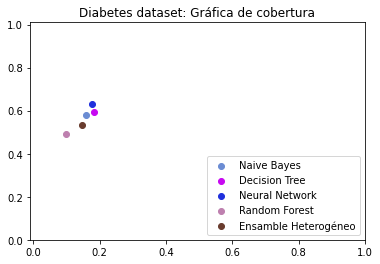

In [67]:
sctr = []
for i in range(5):
    sctr.append(plt.scatter(graphCobertura_dia_ejeX[i],graphCobertura_dia_ejeY[i], color=np.random.random(3)))
plt.axis([-0.01, 1, 0, 1.01])
plt.title("Diabetes dataset: Gráfica de cobertura")
plt.legend([sctr[i] for i in range(5)], namesCL, loc ="lower right") 
plt.show()

#### Ionosphere dataset

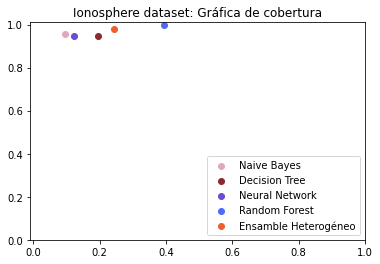

In [25]:
sctr = []
for i in range(5):
    sctr.append(plt.scatter(graphCobertura_ion_ejeX[i],graphCobertura_ion_ejeY[i], color=np.random.random(3)))
plt.axis([-0.01, 1, 0, 1.01])
plt.title("Ionosphere dataset: Gráfica de cobertura")
plt.legend([sctr[i] for i in range(5)], namesCL, loc ="lower right") 
plt.show()

#### Credit approval dataset

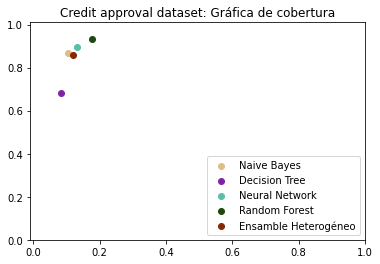

In [53]:
sctr = []
for i in range(5):
    sctr.append(plt.scatter(graphCobertura_cre_ejeX[i],graphCobertura_cre_ejeY[i], color=np.random.random(3)))
plt.axis([-0.01, 1, 0, 1.01])
plt.title("Credit approval dataset: Gráfica de cobertura")
plt.legend([sctr[i] for i in range(5)], namesCL, loc ="lower right") 
plt.show()